# Running Injury Clinic PhD data

Reginaldo K Fukuchi, Jan 2023, reginaldo.fukuchi@ufabc.edu.br

This NB imports mat file containing static and dynamic data of running trials I collected during my PhD at RIC in 2012.

In [3]:
# Prepare environment
import os
import scipy.io as spio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

In [4]:
# Import data
pathname = r'../data'

## Import mat file data
### Helper functions to prepare data
https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries

In [5]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

### Import mat file data

In [6]:
fname    = os.path.join(pathname, '20120821T104617.mat') 
# Import data
data = loadmat(fname)

### Create pandas df from dictionay

In [7]:
mkr_S_labels = list(data['out']['full_static'].keys())

In [8]:
mkr_S_data = np.empty(shape=(200,3*len(mkr_S_labels)))
for m, marker in enumerate(mkr_S_labels):
    mkr_S_data[:,3*m:3*m+3] = np.array(data['out']['full_static'][marker])

In [9]:
df_S = pd.DataFrame(data=mkr_S_data)
mkr_S_labels_2 = [ele for ele in mkr_S_labels for i in range(3)]
df_S.columns = [mkr_S_labels_2, list('XYZ')*len(mkr_S_labels)]
df_S.columns.set_names(names=['Marker', 'Coordinate'], 
                     level=[0, 1], inplace=True)

In [10]:
duration  = data['out']['hz_r']/mkr_S_data.shape[0]
timeStamps= np.linspace(0, duration, mkr_S_data.shape[0])

In [11]:
df_S['Time'] = timeStamps
df_S.set_index('Time', inplace=True)
df_S.index.name = 'Time'

In [12]:
df_S.head()

Marker             RIC                                 LIC             \
Coordinate           X          Y            Z           X          Y   
Time                                                                    
0.000000    690.302979 -24.144964  1186.501953  358.820160 -45.394676   
0.005025    690.303223 -24.149342  1186.498047  358.869385 -45.349300   
0.010050    690.303345 -24.149654  1186.497803  358.778748 -45.391197   
0.015075    690.373108 -24.186714  1186.468872  358.839172 -45.360054   
0.020101    690.344238 -24.152397  1186.469849  358.845856 -45.320061   

Marker                         RASI                                LASI  ...  \
Coordinate            Z           X          Y            Z           X  ...   
Time                                                                     ...   
0.000000    1193.250000  651.372681  58.366940  1110.803223  382.157990  ...   
0.005025    1193.242920  651.432922  58.410744  1110.811401  382.105377  ...   
0.010050    1193.255859  651.415833  58.387333  1110.797974  382.088013  ...   
0.015075    1193.252319  651.402527  58.374546  1110.795410  382.096619  ...   
0.020101    1193.218262  651.387634  58.393387  1110.808594  382.140289  ...   

Marker             LELB          LW                                 RBAK  \
Coordinate            Z           X           Y            Z           X   
Time                                                                       
0.000000    1292.336060  145.004547  217.815277  1287.846191  651.696716   
0.005025    1292.380859  144.968643  217.842819  1287.799316  651.692810   
0.010050    1292.387207  144.960144  217.844437  1287.835938  651.693420   
0.015075    1292.364014  145.000275  217.888351  1287.867554  651.744080   
0.020101    1292.370850  144.964432  217.894638  1287.856079  651.748840   

Marker                                     RARM                          
Coordinate           Y            Z           X          Y            Z  
Time                                                                     
0.000000   -161.044846  1530.513916  813.931702 -37.805531  1399.390259  
0.005025   -160.978165  1530.546875  813.946045 -37.799965  1399.384399  
0.010050   -161.020508  1530.567261  813.948242 -37.797764  1399.387817  
0.015075   -160.980759  1530.528564  813.914124 -37.733063  1399.360474  
0.020101   -160.956314  1530.513306  813.904419 -37.732792  1399.419189  

[5 rows x 183 columns]

<IPython.core.display.Javascript object>


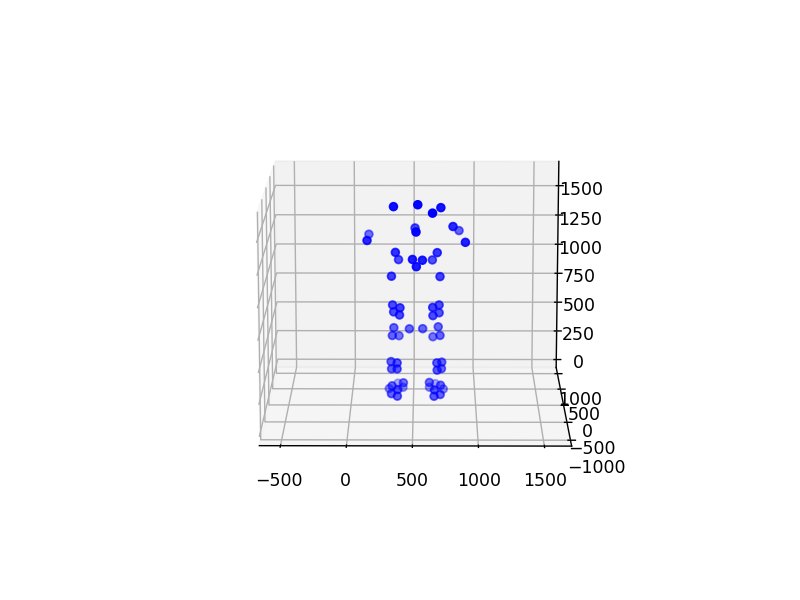

In [13]:
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = df_S.values[100,2::3]
xdata = df_S.values[100,0::3]
ydata = df_S.values[100,1::3]
ax.scatter3D(xdata, ydata, zdata, c='b');
ax.set_aspect('equal')

## Import C3D file using EZC3D
https://c3d.readthedocs.io/en/stable/

In [14]:
from ezc3d import c3d
fname_c3d = os.path.join(pathname,'RBDS001static.c3d')
c = c3d(fname_c3d)

In [15]:
point_data = c['data']['points']
points_residuals = c['data']['meta_points']['residuals']
analog_data = c['data']['analogs']

In [16]:
mkr_S_labels_RBDS = c['parameters']['POINT']['LABELS']['value']

### Create pandas df

In [27]:
mkr_S_data_RBDS = np.empty(shape=(point_data.shape[2],3*len(mkr_S_labels_RBDS)))
for m, marker in enumerate(mkr_S_labels_RBDS):
    mkr_S_data_RBDS[:,3*m:3*m+3] = point_data[:3, m, :].T

In [33]:
df_S_RBDS = pd.DataFrame(data=mkr_S_data_RBDS)
mkr_S_labels_RBDS_2 = [ele for ele in mkr_S_labels_RBDS for i in range(3)]
df_S_RBDS.columns = [mkr_S_labels_RBDS_2, list('XYZ')*len(mkr_S_labels_RBDS)]
df_S_RBDS.columns.set_names(names=['Marker', 'Coordinate'], 
                     level=[0, 1], inplace=True)

In [34]:
df_S_RBDS.head()

Marker         L.Ankle                          L.Ankle.Medial              \
Coordinate           X           Y            Z              X           Y   
0           705.062866  108.774330  1050.909424     725.535095  119.272575   
1           705.066833  108.766876  1050.910889     725.530396  119.266960   
2           705.065430  108.771133  1050.902832     725.532959  119.267067   
3           705.067078  108.770615  1050.907104     725.535950  119.267815   
4           705.060730  108.771179  1050.905151     725.534241  119.267807   

Marker                       L.ASIS                                 L.GTR  \
Coordinate            Z           X            Y            Z           X   
0           1129.002441  876.648743  1067.346436  1126.366577  799.197205   
1           1129.005005  876.686035  1067.344360  1126.387573  799.232788   
2           1129.006104  876.736938  1067.349854  1126.407471  799.294189   
3           1129.002930  876.780396  1067.346436  1126.431274  799.340088   
4           1129.004883  876.821350  1067.347900  1126.442627  799.390625   

Marker      ... R.Thigh.Bottom.Medial R.Thigh.Top.Lateral              \
Coordinate  ...                     Z                   X           Y   
0           ...           1345.514282          725.082825  761.838928   
1           ...           1345.495483          725.089050  761.827515   
2           ...           1345.485840          725.094055  761.832520   
3           ...           1345.468140          725.094055  761.823364   
4           ...           1345.458984          725.103516  761.824829   

Marker                  R.Thigh.Top.Medial                           \
Coordinate            Z                  X           Y            Z   
0           1398.587158         676.568359  760.431702  1347.822632   
1           1398.581421         676.584167  760.432800  1347.808350   
2           1398.583130         676.592529  760.428711  1347.793579   
3           1398.575684         676.612793  760.425476  1347.788452   
4           1398.569946         676.621399  760.423767  1347.771729   

Marker            R.TT                           
Coordinate           X           Y            Z  
0           780.426636  462.710876  1343.646973  
1           780.445190  462.712555  1343.645752  
2           780.457764  462.725372  1343.636353  
3           780.471008  462.721649  1343.632812  
4           780.485840  462.709076  1343.625610  

[5 rows x 144 columns]

In [ ]:
fname_c3d_f = os.path.join(pathname,'RBDS001runT35.c3d')
c3d = c3d(fname_c3d_f, extract_forceplat_data=True);

pf_0 = c3d["data"]["platform"][0]  # Select the first platform

In [ ]:
pf_0['unit_force']          # Units of forces
pf_0['unit_moment']         # Units of moments
pf_0['unit_position']       # Units of center of pressure

pf_0['cal_matrix']          # Calibration matrix
pf_0['corners']             # Position of the corners
pf_0['origin']              # Position of the origin

pf_0['force']               # Force data
pf_0['moment']              # Moment data
pf_0['center_of_pressure']  # Center of pressure data
pf_0['Tz']                  # Moment at center of pressure data

In [ ]:
pf_0['cal_matrix'] 

In [ ]:
    if df_multi:  # dataframe with multiple labels
        df.drop(labels='Frame#', axis=1, inplace=True)
        df.set_index('Time', inplace=True)
        df.index.name = 'Time'
        cols = [s[:-1] for s in df.columns.str.replace(r'.', r'_')]
        df.columns = [cols, list('XYZ')*int(df.shape[1]/3), xyz]
        df.columns.set_names(names=['Marker', 'Coordinate', 'XYZ'],
                             level=[0, 1, 2], inplace=True)

In [ ]:
mkr_S_data.shape

In [ ]:
df_s = pd.DataFrame.from_dict(data['out']['full_static'])
df_s.head()

In [ ]:
data['out']['full_static']

In [ ]:
print(data['out'].keys())

In [ ]:
data['out']['neutral'].keys()

In [ ]:
data['out']['full_static'].keys()

In [ ]:
data['out'][0][0]

In [ ]:
data['__header__']

### Data stored in RBA directory

In [ ]:
fname_q= os.path.join(pathname, 'RBDS_google_forms.csv') 
# Import data
data_q = pd.read_csv(fname_q, sep = ',', index_col = 'ID')
data_q.head()

In [ ]:
df_rba = data_q[['Altura (cm)','Massa (kg)']]
df_rba

In [ ]:
df_figshare = info[['Subject','Height','Mass']]
df_figshare.set_index('Subject')

In [ ]:
df_out = df_rba.loc[df_rba['Altura (cm)']==df_figshare['Height'].values[5]]
df_out.index.tolist()

In [ ]:
ids = []
for i in range(df_figshare.shape[0]):
    df_out = df_rba.loc[(df_rba['Altura (cm)']==df_figshare['Height'].values[i]) & (df_rba['Massa (kg)']==df_figshare['Mass'].values[i])]
    if df_out.empty:
        print('Subject '+ str(df_figshare['Subject'].values[i]) + ' not found!')
    else:
        ids.append(df_out.index.tolist())

In [ ]:
ids

# PENDING
* Find who is who. 
Find the subjects in Figshare RBDSinfo.txt with the corresponding ID in RBA spreadsheet